In [1]:
import numpy as np
import pandas as pd

## Data

In [2]:
data = pd.read_csv('fraud_dataset.csv')

In [3]:
data.head()

,transaction_id,transaction_amount,location,merchant,age,gender,fraud_label
0,1,1000.0,New York,ABC Corp,35,M,0
1,2,500.0,Chicago,XYZ Inc,45,F,0
2,3,2000.0,Los Angeles,ABC Corp,28,M,1
3,4,1500.0,San Francisco,XYZ Inc,30,F,0
4,5,800.0,Chicago,ABC Corp,50,F,0


## Select the interested Data

In [4]:
# we dont need the transaction_id for our model, so split it out
interested_data = data.iloc[:, 1:]

In [5]:
interested_data.head()

,transaction_amount,location,merchant,age,gender,fraud_label
0,1000.0,New York,ABC Corp,35,M,0
1,500.0,Chicago,XYZ Inc,45,F,0
2,2000.0,Los Angeles,ABC Corp,28,M,1
3,1500.0,San Francisco,XYZ Inc,30,F,0
4,800.0,Chicago,ABC Corp,50,F,0


In [6]:
interested_data.describe()

,transaction_amount,age,fraud_label
count,86.000000,86.000000,86.000000
mean,1623.430233,40.081395,0.186047
std,799.196016,8.829383,0.391427
min,500.000000,26.000000,0.000000
25%,950.000000,32.250000,0.000000
50%,1375.000000,39.500000,0.000000
75%,2000.000000,47.750000,0.000000
max,4000.000000,56.000000,1.000000


## Mapping the categorical Data

In [7]:
interested_data['location'].unique()

array(['New York', 'Chicago', 'Los Angeles', 'San Francisco'],
      dtype=object)

In [8]:
interested_data['merchant'].unique()

array(['ABC Corp', 'XYZ Inc'], dtype=object)

In [9]:
interested_data['gender'] = interested_data['gender'].map({'M': 0, 'F': 1})

In [10]:
interested_data['merchant'] = interested_data['merchant'].map({'ABC Corp': 0, 'XYZ Inc': 1})

## Missing values

In [11]:
interested_data.isnull().sum()

transaction_amount    0
location              0
merchant              0
age                   0
gender                0
fraud_label           0
dtype: int64

## Outiliers

C:\Users\42128\AppData\Local\Temp\ipykernel_34068\3991929192.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(interested_data['transaction_amount'])


<Axes: xlabel='transaction_amount', ylabel='Density'>

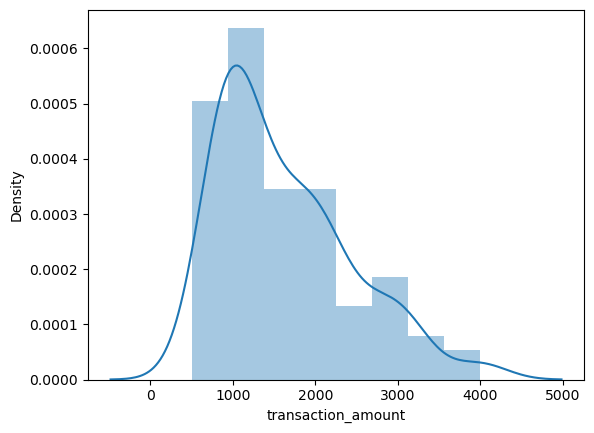

In [12]:
import seaborn as sns
# check how the values in transaction amount are distributed
sns.distplot(interested_data['transaction_amount'])

#### The values are skew to the right means we have to quantile the top N percent to reduce the prediction errors

C:\Users\42128\AppData\Local\Temp\ipykernel_34068\1417594805.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(interested_data['age'])


<Axes: xlabel='age', ylabel='Density'>

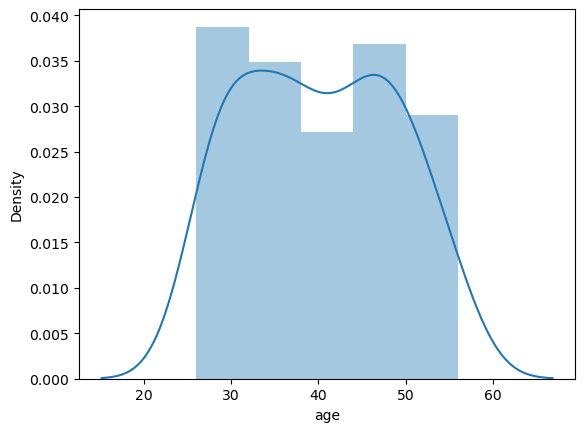

In [13]:
# check how the values in age are distributed
sns.distplot(interested_data['age'])

The kewness does not specifically leaning towrad left or right 

## Get input and output

In [14]:
input_data = interested_data.iloc[:, :len(interested_data.columns)-1]
target_data = interested_data['fraud_label']

In [15]:
input_data.head()

,transaction_amount,location,merchant,age,gender
0,1000.0,New York,0,35,0
1,500.0,Chicago,1,45,1
2,2000.0,Los Angeles,0,28,0
3,1500.0,San Francisco,1,30,1
4,800.0,Chicago,0,50,1


## Get dummies

In [16]:
# get the dummies to replace the categorical data with numerical values
dummies_data = pd.get_dummies(input_data, dtype=int, drop_first=True)
dummies_data.head()

,transaction_amount,merchant,age,gender,location_Los Angeles,location_New York,location_San Francisco
0,1000.0,0,35,0,0,1,0
1,500.0,1,45,1,0,0,0
2,2000.0,0,28,0,1,0,0
3,1500.0,1,30,1,0,0,1
4,800.0,0,50,1,0,0,0


## Feature Selecion 

In [17]:
# import the library for selection
from sklearn.feature_selection import f_regression

In [18]:
# calculate the p_values for each input variable
p_values = f_regression(dummies_data, target_data)

# round the p_values to the third digit
p_values = p_values[1].round(3)

# create a table to disply the p values
p_table = pd.DataFrame({'Features': dummies_data.columns, 'P_values': p_values})
p_table

,Features,P_values
0,transaction_amount,0.000
1,merchant,0.273
2,age,0.845
3,gender,0.585
4,location_Los Angeles,0.062
5,location_New York,0.050
6,location_San Francisco,0.008


#### I decide to remove age and gender since the their p_value shows they do not have a significant effect on the model

In [19]:
#dummies_data = dummies_data.drop(['age', 'gender'], axis=1)

In [20]:
input_data_preprcoessed = dummies_data.copy().reset_index(drop=True)
target_data = target_data.reset_index(drop=True)

## Balance the data

I need to balance the target data otherwise if there are more fraud accounts than without fraud accounts. The model will tend to predict the fraud likely.

In [21]:
fraud_counts = np.sum(target_data)
print(len(target_data), fraud_counts)

86 16


In [22]:
def balance(target_data):
    fraud_count = np.sum(target_data)
    noFraud_count = 0
    
    index = 0
    removed_indices = []
    
    for i in target_data:
        if i == 0:
            noFraud_count += 1
            if noFraud_count > fraud_count:
                removed_indices.append(index)
        index += 1
    return removed_indices   

In [23]:
removed_indices = balance(target_data)

In [24]:
balanced_input_data = input_data_preprcoessed.drop(removed_indices, axis=0).reset_index(drop=True)
balanced_target_data = target_data.drop(removed_indices, axis=0).reset_index(drop=True)

## Standardize input data

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
scale = StandardScaler()
scale.fit(balanced_input_data, balanced_target_data)

StandardScaler()

In [27]:
scaled_input_data = scale.transform(balanced_input_data)

## Shuffle

In [28]:
# import random to shuffle the data because I balanced the data in a series of 00001111
import random

# get indices of scaled_input_data
shuffled_indices = list(range(scaled_input_data.shape[0]))

# shuffle their its
random.shuffle(shuffled_indices)

In [29]:
# update the data in a new order
shuffled_input_data = scaled_input_data[shuffled_indices]
shuffled_target_data = balanced_target_data[shuffled_indices]

## Split

In [30]:
total_sample_counts = shuffled_input_data.shape[0]
train_counts = int(0.8*total_sample_counts)
test_counts = total_sample_counts - train_counts

In [31]:
print(total_sample_counts, train_counts, test_counts)

32 25 7


In [32]:
train_input = shuffled_input_data[:train_counts]
train_target = shuffled_target_data[:train_counts]

test_input = shuffled_input_data[train_counts: ]
test_target = shuffled_target_data[train_counts: ]

## Logistic regression

In [33]:
# import the Logistic Regression to build the model
from sklearn.linear_model import LogisticRegression

In [1]:
classifier = LogisticRegression(random_state=0)

# fit the model with data
classifier.fit(train_input, train_target)

NameError: name 'LogisticRegression' is not defined

#### calaculate the residual values and plot them into a distribution graph we can see it is normal distributed which mean the model is great

## Testing

In [35]:
# import the confusion_matrix to get the probability of getting a correct outpout
from sklearn.metrics import confusion_matrix

# predict the outputs by the test_input 
test_outputs = classifier.predict(test_input)

# get the confusion matrix
cm = confusion_matrix(test_target, test_outputs)
cm

array([[3, 0],
       [1, 3]], dtype=int64)

In [36]:
# construct a datagrame to display the cm
cm_table = pd.DataFrame(cm)
cm_table.columns = ['Prediction 0', 'Preidction 1']
cm_table = cm_table.rename(index={0: 'Prediction 0', 1: 'Prediction 1'})
cm_table

,Prediction 0,Preidction 1
Prediction 0,3,0
Prediction 1,1,3


In [37]:
# get the accuracy
from sklearn import metrics
test_accuracy = metrics.accuracy_score(test_outputs, test_target)
print('The test accuracy is ' + str(test_accuracy.round(2)*100))

The test accuracy is 86.0


#### The model sometimes may have a bad accuracy due to shuffling because shuffling may put many 0 or 1 predictions into the test dataset